<a href="https://colab.research.google.com/github/punitvara/ml-practice-notebook/blob/master/telestra_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
severity_type = pd.read_csv('severity_type.csv', error_bad_lines= False, warn_bad_lines= False)
resource_type = pd.read_csv('resource_type.csv', error_bad_lines= False, warn_bad_lines= False)
log_failure = pd.read_csv('log_feature.csv', error_bad_lines= False, warn_bad_lines= False)
event_type = pd.read_csv('event_type.csv', error_bad_lines=False, warn_bad_lines= False)


In [0]:
!pip3 install catboost
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from rrf import RefinedRandomForest
from catboost import CatBoostClassifier

     |████████████████████████████████| 63.6MB 35kB/s 


In [0]:
print("test",test.shape)
print("train",train.shape)

test (11171, 2)
train (7381, 3)


In [0]:
print('test',test.head())
print('train',train.head(4))
#print('sample_submission',sample_submission.head())
print('event_type',event_type.shape,event_type.head(2))
print('severity_type',severity_type.shape,severity_type.head(2))
print('log_feature',log_failure.shape,log_failure.head(2))
print('resource_type',resource_type.shape,resource_type.head(2))


test       id      location
0  11066  location 481
1  18000  location 962
2  16964  location 491
3   4795  location 532
4   3392  location 600
train       id      location  fault_severity
0  14121  location 118               1
1   9320   location 91               0
2  14394  location 152               1
3   8218  location 931               1
event_type (31170, 2)      id     event_type
0  6597  event_type 11
1  8011  event_type 15
severity_type (18552, 2)      id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
log_feature (58671, 3)      id log_feature  volume
0  6597  feature 68       6
1  8011  feature 68       7
resource_type (21076, 2)      id    resource_type
0  6597  resource_type 8
1  8011  resource_type 8


In [0]:
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

In [0]:
train_merge1=merge_fn(train,event_type.drop_duplicates(subset=['id']),'id','left')
train_merge2=merge_fn(train_merge1,severity_type.drop_duplicates(subset=['id']),'id','left')
train_merge3=merge_fn(train_merge2,log_failure.drop_duplicates(subset=['id']),'id','left')
train_merge4=merge_fn(train_merge3,resource_type.drop_duplicates(subset=['id']),'id','left')

In [0]:
train_merge4.shape


(7381, 8)

In [0]:
train_merge4.head()

,id,location,fault_severity,event_type,severity_type,log_feature,volume,resource_type
0,14121,location 118,1,event_type 34,severity_type 2,feature 312,19,resource_type 2
1,9320,location 91,0,event_type 34,severity_type 2,feature 315,200,resource_type 2
2,14394,location 152,1,event_type 35,severity_type 2,feature 221,1,resource_type 2
3,8218,location 931,1,event_type 15,severity_type 1,feature 80,9,resource_type 8
4,14804,location 120,0,event_type 34,severity_type 1,feature 134,1,resource_type 2


In [0]:
plt.figure(figsize = (10,8))
#sns.countplot(train_merge4['severity_type'])
#plt.show()

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [0]:
plt.figure(figsize = (14,6))
#sns.countplot(train_merge4['resource_type'])
plt.tight_layout()
#plt.show()

<Figure size 1008x432 with 0 Axes>

In [0]:
cat_col=list(set(train_merge4.columns)-set(train_merge4._get_numeric_data().columns))

In [0]:
def categorical_conversion(df,cat_col):
    for i in range(len(cat_col)):
        df[cat_col[i]]=df[cat_col[i]].astype('category')
    return df

In [0]:
train_merge4=categorical_conversion(train_merge4,cat_col) 

In [0]:
train_merge4.dtypes

id                   int64
location          category
fault_severity       int64
event_type        category
severity_type     category
log_feature       category
volume               int64
resource_type     category
dtype: object

In [0]:
def label_encoding_conversion(df,cat_col):
    le=preprocessing.LabelEncoder()
    for i in range(len(cat_col)):
        df[cat_col[i]]=le.fit_transform(df[cat_col[i]])
    return df

In [0]:
train_merge4.columns

Index(['id', 'location', 'fault_severity', 'event_type', 'severity_type',
       'log_feature', 'volume', 'resource_type'],
      dtype='object')

In [0]:
train_merge4=label_encoding_conversion(train_merge4,cat_col)

In [0]:
train_merge4.drop(['id'],axis=1,inplace=True)

In [0]:
target=train_merge4[['fault_severity']]

In [0]:
train_merge4.drop(['fault_severity'],axis=1,inplace=True)

In [0]:
train_merge4.head()

,location,event_type,severity_type,log_feature,volume,resource_type
0,131,22,1,143,19,2
1,850,22,1,146,200,2
2,163,23,1,88,1,2
3,870,5,0,211,9,8
4,134,22,0,21,1,2


In [0]:
print("train",train_merge4.shape)

train (7381, 6)


In [0]:
test_merge1=merge_fn(test,event_type.drop_duplicates(subset=['id']),'id','left')
test_merge2=merge_fn(test_merge1,severity_type.drop_duplicates(subset=['id']),'id','left')
test_merge3=merge_fn(test_merge2,log_failure.drop_duplicates(subset=['id']),'id','left')
test_merge4=merge_fn(test_merge3,resource_type.drop_duplicates(subset=['id']),'id','left')

In [0]:
test_merge4.shape

(11171, 7)

In [0]:
test_merge4=categorical_conversion(test_merge4,cat_col)

In [0]:
test_merge4=label_encoding_conversion(test_merge4,cat_col)

In [0]:
test_merge4.drop(['id'],axis=1,inplace=True)

In [0]:
train_merge4.columns

Index(['location', 'event_type', 'severity_type', 'log_feature', 'volume',
       'resource_type'],
      dtype='object')

In [0]:
lr=LogisticRegression(C=1e2)
lr.fit(train_merge4,target)
lr_pred=lr.predict(test_merge4)
lr_proba = lr.predict_proba(train_merge4)
As = accuracy_score(pd.DataFrame(lr.predict(train_merge4)),target)
print (As)
ll_lr = log_loss( target, lr_proba)
print (ll_lr) 

0.6501829020457932
0.7755159465425586


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [0]:
cm=confusion_matrix(pd.DataFrame(lr.predict(train_merge4)),target)


In [0]:
cf=classification_report(pd.DataFrame(lr.predict(train_merge4)),target)

In [0]:
print(cm)
print(cf)

[[4679 1755  689]
 [  93  113   30]
 [  12    3    7]]
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      7123
           1       0.06      0.48      0.11       236
           2       0.01      0.32      0.02        22

    accuracy                           0.65      7381
   macro avg       0.35      0.48      0.30      7381
weighted avg       0.95      0.65      0.76      7381



In [0]:
rf= RandomForestClassifier()
rf.fit(train_merge4,target)
rf_pred=rf.predict(test_merge4)
rf_proba = rf.predict_proba(train_merge4)
accuracy_score(pd.DataFrame(rf.predict(train_merge4)),target)
ll_rf = log_loss(target, rf_proba)
print (ll_rf)

0.187746421207031


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [0]:
cm=confusion_matrix(pd.DataFrame(rf.predict(train_merge4)),target)


In [0]:
cf=classification_report(pd.DataFrame(rf.predict(train_merge4)),target)

In [0]:
print(cm)
print(cf)

[[4672  142   54]
 [  88 1701   35]
 [  24   28  637]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4868
           1       0.91      0.93      0.92      1824
           2       0.88      0.92      0.90       689

    accuracy                           0.95      7381
   macro avg       0.92      0.94      0.93      7381
weighted avg       0.95      0.95      0.95      7381



In [0]:
cb = CatBoostClassifier(depth=10, learning_rate=0.25, verbose=False)
cb.fit(train_merge4,target)
cb_pred=cb.predict(test_merge4)
cb_proba = cb.predict_proba(train_merge4)
accuracy_score(pd.DataFrame(cb.predict(train_merge4)),target)

cm=confusion_matrix(pd.DataFrame(cb.predict(train_merge4)),target)
cf=classification_report(pd.DataFrame(cb.predict(train_merge4)),target)
ll_cb = log_loss(target, cb_proba) 
print(ll_cb)
print(cm)
print(cf)
#print (cf["0"]["precision"], cf["0"]["recall"], cf["0"]["f1-score"])


0.20558286719642418
[[4644  208   49]
 [ 116 1637   34]
 [  24   26  643]]
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      4901
         1.0       0.87      0.92      0.90      1787
         2.0       0.89      0.93      0.91       693

    accuracy                           0.94      7381
   macro avg       0.91      0.93      0.92      7381
weighted avg       0.94      0.94      0.94      7381



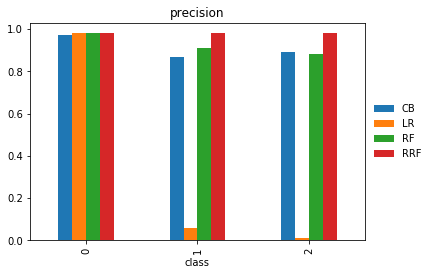

In [0]:
#import pandas as pd
df = pd.DataFrame([['0','LR',0.98],['0','RF',0.98],['0','CB',0.97],['0','RRF',0.98],['1','LR',0.06],
                   ['1','RF',0.91],['1','CB',0.87],['1','RRF',0.98],['2','LR',0.01],['2','RF',0.88],['2','CB',0.89], ['2','RRF',0.98]],columns=['class','precision','val'])
df.pivot("class","precision","val").plot(kind='bar', title="precision")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.show()

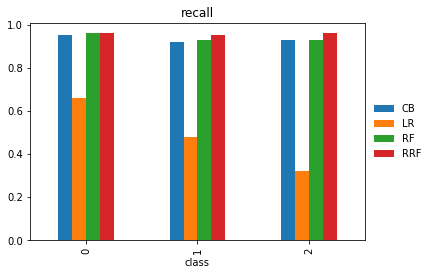

In [0]:
df = pd.DataFrame([['0','LR',0.66],['0','RF',0.96],['0','CB',0.95],['0','RRF',0.96],['1','LR',0.48],
                   ['1','RF',0.93],['1','CB',0.92],['1','RRF',0.95],['2','LR',0.32],['2','RF',0.93],['2','CB',0.93], ['2','RRF',0.96]],columns=['class','recall','val'])
df.pivot("class","recall","val").plot(kind='bar', title='recall')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.show()

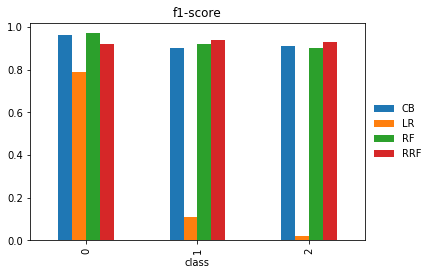

In [0]:
df = pd.DataFrame([['0','LR',0.79],['0','RF',0.97],['0','CB',0.96],['0','RRF',0.92],['1','LR',0.11],
                   ['1','RF',0.92],['1','CB',0.90],['1','RRF',0.94],['2','LR',0.02],['2','RF',0.90],['2','CB',0.91], ['2','RRF',0.93]],columns=['class','f1-score','val'])
df.pivot("class","f1-score","val").plot(kind='bar', title="f1-score")
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.show()

In [0]:
refined_rf = RefinedRandomForest(rf, C = 1e2, n_prunings = 0)
refined_rf.fit(train_merge4,target)
refined_rf_pred=refined_rf.predict_proba(test_merge4)
refined_proba = refined_rf.predict_proba(train_merge4)
refined_rf_pred = np.argmax(refined_rf_pred,axis=1)

redfined_rf_on_training = np.argmax(refined_rf.predict_proba(train_merge4),axis=1)
accuracy_score(pd.DataFrame(redfined_rf_on_training),target)

cm=confusion_matrix(pd.DataFrame(redfined_rf_on_training),target)
cf=classification_report(pd.DataFrame(redfined_rf_on_training),target, output_dict=False)
ll_rrf = log_loss(target, refined_proba) 

#print (cf["0"]["precision"], cf["0"]["recall"], cf["0"]["f1-score"])
print(ll_rrf)
print(cm)
print(cf)
plt.figure(figsize = (10,7))
#sns.heatmap(cm, annot=True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.04848261769798362
[[4700   62   35]
 [  63 1788   22]
 [  21   21  669]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4797
           1       0.96      0.95      0.96      1873
           2       0.92      0.94      0.93       711

    accuracy                           0.97      7381
   macro avg       0.95      0.96      0.96      7381
weighted avg       0.97      0.97      0.97      7381



<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

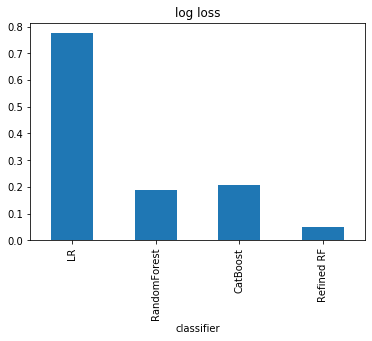

In [0]:

x = [ll_lr, ll_rf, ll_cb, ll_rrf]
clf = ["LR","RandomForest","CatBoost","Refined RF"]
#r = ["green","red","blue", "yellow"]
#df = pd.DataFrame([["classifier", "log-loss"],["LR", ll_lr],["RF",ll_rf], ["CB",ll_cb], ["RRF", ll_rrf]])
#plt.bar(clf, x)
# df = pd.DataFrame({'month': [1, 4, 7, 10],
# ...                    'year': [2012, 2014, 2013, 2014],
# ...                    'sale': [55, 40, 84, 31]})
df = pd.DataFrame({'classifier': clf, 'values': x})
#df.set_index('classifier')
df.plot(kind='bar', title="log loss", legend=False, x="classifier", y="values" )

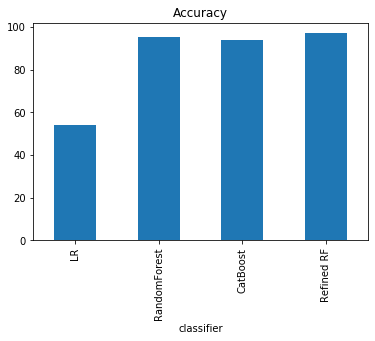

In [0]:
x = [54, 95, 94,97]
clf = ["LR","RandomForest","CatBoost","Refined RF"]
df = pd.DataFrame({'classifier': clf, 'values': x})
df.plot(kind='bar', title="Accuracy", legend=False, x="classifier", y="values" )
